# Setup

In [1]:
!cat /proc/meminfo | grep 'MemAvailable'

MemAvailable:   25779364 kB


In [2]:
!df -h / | awk '{print $4}'

Avail
306G


In [3]:
%mkdir data
%cd data

/content/data


In [4]:
# we will download the training data locally because it's too large for Google Drive (~70GB)
%%bash
wget http://images.cocodataset.org/zips/train2014.zip -c
wget http://images.cocodataset.org/zips/val2014.zip -c
wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -c
unzip train2014.zip
unzip val2014.zip
unzip annotations_trainval2014.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
%cd annotations
import zipfile
import urllib.request
import shutil

annZipFile = "instances_minival2014.json.zip"
annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
unZipDir = "."

with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
    shutil.copyfileobj(resp, out)
with zipfile.ZipFile(annZipFile, "r") as zip_ref:
    zip_ref.extractall(unZipDir)

annZipFile = "instances_valminusminival2014.json.zip"
annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
    shutil.copyfileobj(resp, out)
with zipfile.ZipFile(annZipFile, "r") as zip_ref:
    zip_ref.extractall(unZipDir)

!ls

/content/data/annotations
captions_train2014.json		instances_val2014.json
captions_val2014.json		instances_valminusminival2014.json
instances_minival2014.json	instances_valminusminival2014.json.zip
instances_minival2014.json.zip	person_keypoints_train2014.json
instances_train2014.json	person_keypoints_val2014.json


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
# we want to save the repo on drive so that we won't lose training checkpoints
%cd /content/drive/My Drive
!git clone https://github.com/shuheng-cao/Paper-Implementation-and-Deployment.git
%cd Paper-Implementation-and-Deployment
!git pull

/content/drive/My Drive
fatal: destination path 'Paper-Implementation-and-Deployment' already exists and is not an empty directory.
/content/drive/My Drive/Paper-Implementation-and-Deployment
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 2), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/shuheng-cao/Paper-Implementation-and-Deployment
   db3803f..617940b  master     -> origin/master
Updating db3803f..617940b
Fast-forward
 Mask RCNN/.DS_Store        | Bin 6148 -> 6148 bytes
 Mask RCNN/test_image/1.jpg | Bin 0 -> 51446 bytes
 Mask RCNN/test_image/2.jpg | Bin 0 -> 68354 bytes
 Mask RCNN/test_image/3.jpg | Bin 0 -> 213567 bytes
 4 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Mask RCNN/test_image/1.jpg
 create mode 100644 Mask RCNN/test_image/2.jpg
 create mode 100644 Mask RCNN/test_image/3.jpg


In [0]:
%cd /content/drive/My\ Drive/Paper-Implementation-and-Deployment/Mask\ RCNN
!ls

In [2]:
!pip install -r 'requirements.txt' 
!python setup.py install
!pip show mask-rcnn

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mrcnn/inference.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/data_utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/inference.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model_utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/

# Build the Mask RCNN Training Model

In [3]:
import os
import sys
import numpy as np
import tensorflow as tf
import keras
from keras import backend, layers, engine, models

from mrcnn.config import Config
from mrcnn import utils, data_utils as data, model_utils

# Requires TensorFlow 1.3+ and Keras 2.0.8+.
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion("1.3")
assert LooseVersion(keras.__version__) >= LooseVersion('2.0.8')

Using TensorFlow backend.


In [0]:
# Root directory of the project
ROOT_DIR = "/content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Set up hyperparameters

In [0]:
# argument parse
class Args():
    dataset = "/content/data"
    year = "2014"
    model = "last" # we want to use last trained model
    # model = "coco" # we want to use coco pretrained model
    # model = "new" # we start from a new model
    limit = 500 # images used for evaluation
    epoch = None
    log_dir = None
    checkpoint_path = None
    model_dir = "/content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs"
args = Args()
if args.model == "new" or args.model == "last": # warning, if you choose last, select your last backbone
    args.backbone = "resnet50"
else:
    args.backbone = "resnet101"

In [6]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    IMAGES_PER_GPU = 1

    BACKBONE = args.backbone
    # Number of classes (including background)
    if args.model == "new" or args.model == "last": # warning, if you choose last, select your last numbber of class
        NUM_CLASSES = 5 + 1  # we trained on the first 5 classes + background
    else:
        NUM_CLASSES = 1 + 80  # COCO has 80 classes

# Training Configurations
config = CocoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Build the Training Model

### Input Layer

In [14]:
# Image size must be dividable by 2 multiple times
h, w = config.IMAGE_SHAPE[:2]
assert h / 2**6 == int(h / 2**6) and w / 2**6 == int(w / 2**6)

# Inputs
input_image = layers.Input(shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
input_image_meta = layers.Input(shape=[config.IMAGE_META_SIZE], name="input_image_meta")

# RPN GT
input_rpn_match = layers.Input(shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
input_rpn_bbox = layers.Input(shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

# Detection GT (class IDs, bounding boxes, and masks)
# 1. GT Class IDs (zero padded)
input_gt_class_ids = layers.Input(shape=[None], name="input_gt_class_ids", dtype=tf.int32)

# 2. GT Boxes in pixels (zero padded)
# [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
input_gt_boxes = layers.Input(shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)

# Normalize coordinates
gt_boxes = layers.Lambda(lambda x: utils.norm_boxes_graph(x, backend.shape(input_image)[1:3]))(input_gt_boxes)

# 3. GT Masks (zero padded)
# [batch, height, width, MAX_GT_INSTANCES]
if config.USE_MINI_MASK:
    input_gt_masks = layers.Input(shape=[config.MINI_MASK_SHAPE[0], config.MINI_MASK_SHAPE[1], None],
                              name="input_gt_masks", dtype=bool)
else:
    input_gt_masks = layers.Input(shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                              name="input_gt_masks", dtype=bool)

### FPN (Feature Pyramid Network) Layer

In [15]:
# Build the shared convolutional layers.
# Bottom-up Layers
# Returns a list of the last layers of each stage, 5 in total.
# Don't create the thead (stage 5), so we pick the 4th item in the list.
_, C2, C3, C4, C5 = model_utils.resnet_graph(input_image, config.BACKBONE, stage5=True, train_bn=config.TRAIN_BN)

# Top-down Layers
P5 = layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
P4 = layers.Add(name="fpn_p4add")([
    layers.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
    layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)
])
P3 = layers.Add(name="fpn_p3add")([
    layers.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
    layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)
])
P2 = layers.Add(name="fpn_p2add")([
    layers.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
    layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)
])

# Attach 3x3 conv to all P layers to get the final feature maps.
P2 = layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
P3 = layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
P4 = layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
P5 = layers.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)

# P6 is used for the 5th anchor scale in RPN. Generated by
# subsampling from P5 with stride of 2.
P6 = layers.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

# Note that P6 is used in RPN, but not in the classifier heads.
rpn_feature_maps = [P2, P3, P4, P5, P6]
mrcnn_feature_maps = [P2, P3, P4, P5]

### RPN (Region Proposal Network) Layer

In [0]:
anchors = data.get_anchors(config, config.IMAGE_SHAPE)
# Duplicate across the batch dimension because Keras requires it
anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
# A hack to get around Keras's bad support for constants
anchors = layers.Lambda(lambda x: tf.Variable(anchors), name="anchors")(input_image)

feature_map = layers.Input(shape=[None, None, config.TOP_DOWN_PYRAMID_SIZE], name="input_rpn_feature_map")
anchors_per_location = len(config.RPN_ANCHOR_RATIOS)

In [0]:
# Builds the computation graph of Region Proposal Network.
# Shared convolutional base of the RPN
shared = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=config.RPN_ANCHOR_STRIDE,
                       name='rpn_conv_shared')(feature_map)

# Anchor Score. [batch, height, width, anchors per location * 2].
x = layers.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

# Reshape to [batch, anchors, 2]
rpn_class_logits = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

# Softmax on last dimension of BG/FG.
rpn_probs = layers.Activation("softmax", name="rpn_class_xxx")(rpn_class_logits)

# Bounding box refinement. [batch, H, W, anchors per location * depth]
# where depth is [x, y, log(w), log(h)]
x = layers.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

# Reshape to [batch, anchors, 4]
rpn_bbox = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)

rpn = models.Model([feature_map], [rpn_class_logits, rpn_probs, rpn_bbox], name="rpn_model")

In [0]:
# Loop through pyramid layers
layer_outputs = []  # list of lists
for p in rpn_feature_maps:
    layer_outputs.append(rpn([p]))
# Concatenate layer outputs
# Convert from list of lists of level outputs to list of lists
# of outputs across levels.
# e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
outputs = list(zip(*layer_outputs))
outputs = [layers.Concatenate(axis=1, name=n)(list(o)) for o, n in zip(outputs, output_names)]

rpn_class_logits, rpn_class, rpn_bbox = outputs

In [0]:
# Generate proposals
# Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates and zero padded.
proposal_count = config.POST_NMS_ROIS_TRAINING
rpn_rois = model_utils.ProposalLayer(
    proposal_count=proposal_count,
    nms_threshold=config.RPN_NMS_THRESHOLD,
    name="ROI",
    config=config)([rpn_class, rpn_bbox, anchors])

In [0]:
# Class ID mask to mark class IDs supported by the dataset the image came from.
active_class_ids = layers.Lambda(lambda x: data.parse_image_meta_graph(x)["active_class_ids"])(input_image_meta)

if not config.USE_RPN_ROIS:
    # Ignore predicted ROIs and use ROIs provided as an input.
    input_rois = layers.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4], name="input_roi", dtype=np.int32)
    # Normalize coordinates
    target_rois = layers.Lambda(lambda x: norm_boxes_graph(x, backend.shape(input_image)[1:3]))(input_rois)
else:
    target_rois = rpn_rois

### Detection Target Layer

In [21]:
# Generate detection targets
# Subsamples proposals and generates target outputs for training
# Note that proposal class IDs, gt_boxes, and gt_masks are zero
# padded. Equally, returned rois and targets are zero padded.
rois, target_class_ids, target_bbox, target_mask =\
    model_utils.DetectionTargetLayer(config, name="proposal_targets")(
        [target_rois, input_gt_class_ids, gt_boxes, input_gt_masks]
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


### Network Heads

In [0]:
mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
    model_utils.fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

mrcnn_mask = model_utils.build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

In [0]:
output_rois = layers.Lambda(lambda x: x * 1, name="output_rois")(rois)

In [0]:
# Losses
rpn_class_loss = layers.Lambda(lambda x: model_utils.rpn_class_loss_graph(*x), name="rpn_class_loss")([input_rpn_match, rpn_class_logits])
rpn_bbox_loss = layers.Lambda(lambda x: model_utils.rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")([input_rpn_bbox, input_rpn_match, rpn_bbox])
class_loss = layers.Lambda(lambda x: model_utils.mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")([target_class_ids, mrcnn_class_logits, active_class_ids])
bbox_loss = layers.Lambda(lambda x: model_utils.mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")([target_bbox, target_class_ids, mrcnn_bbox])
mask_loss = layers.Lambda(lambda x: model_utils.mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")([target_mask, target_class_ids, mrcnn_mask])

### Build the Model

In [0]:
# Model
inputs = [input_image, input_image_meta, input_rpn_match, input_rpn_bbox, 
          input_gt_class_ids, input_gt_boxes, input_gt_masks]
if not config.USE_RPN_ROIS:
    inputs.append(input_rois)
outputs = [rpn_class_logits, rpn_class, rpn_bbox,
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
            rpn_rois, output_rois,
            rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
model = models.Model(inputs, outputs, name='mask_rcnn')

# Train on COCO Dataset

## Data Preparation

In [26]:
# Training dataset. Use the training set and 35K from the validation set, as mentioned in the Mask RCNN paper.
dataset_train = data.CocoDataset()
if args.model == "new" or args.model == "last":
    dataset_train.load_coco(args.dataset, "valminusminival", year=args.year, class_ids=[i+1 for i in range(5)])
else:
    dataset_train.load_coco(args.dataset, "train", year=args.year)
dataset_train.prepare()

# Validation dataset
dataset_val = data.CocoDataset()
val_type = "val" if args.year in '2017' else "minival"
if args.model == "new" or args.model == "last":
    dataset_val.load_coco(args.dataset, val_type, year=args.year, class_ids=[i+1 for i in range(5)])
else:
    dataset_val.load_coco(args.dataset, val_type, year=args.year)
dataset_val.prepare()

# Image Augmentation
# Right/Left flip 50% of the time
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)
augmentation = imgaug.augmenters.Fliplr(0.5)

loading annotations into memory...
Done (t=5.04s)
creating index...
index created!
loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


## Loading Pretrained Model

In [0]:
# Select weights file to load
if args.model.lower() == "coco":
    model_path = COCO_MODEL_PATH
elif args.model.lower() == "last":
    # Find last trained weights
    model_path = utils.find_last(args, config.NAME.lower())
elif args.model.lower() == "new":
    # start new train from resnet50 (101 is too complicated for Colab)
    model_path = utils.get_resnet50_weights()
else:
    raise ValueError("model must be model/last/new")
# NOTE: This will throw out an error if you don't have a pretrained model
# change the args to either new or coco

In [30]:
# Load weights
print("Loading weights ", model_path)
utils.load_weights(model, model_path, args, config, by_name=True)

Loading weights  /content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs/coco20191122T0242/mask_rcnn_coco_0161.h5






Re-starting from epoch 161


## Model Training

In [0]:
# Training - Stage 1
print("Training network heads")
model_utils.train(model, config, args, dataset_train, dataset_val,
                  learning_rate=config.LEARNING_RATE,
                  epochs=40,
                  layers='heads',
                  augmentation=augmentation)

Training network heads

Starting at epoch 160. LR=0.001

Checkpoint Path: /content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs/coco20191122T0242/mask_rcnn_coco_{epoch:04d}.h5
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [0]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model_utils.train(model, config, args, dataset_train, dataset_val,
                  learning_rate=config.LEARNING_RATE,
                  epochs=120,
                  layers='4+',
                  augmentation=augmentation)

Fine tune Resnet stage 4 and up

Starting at epoch 160. LR=0.001

Checkpoint Path: /content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs/coco20191122T0242/mask_rcnn_coco_{epoch:04d}.h5
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (B

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

In [0]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model_utils.train(model, config, args, dataset_train, dataset_val,
                  learning_rate=config.LEARNING_RATE / 10,
                  epochs=160,
                  layers='all',
                  augmentation=augmentation)

Fine tune all layers

Starting at epoch 160. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs/coco20191122T0242/mask_rcnn_coco_{epoch:04d}.h5
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

# Build the Mask RCNN Inference Model

This is very similar to training model so I won't repeat the building process in the notebook.

In [0]:
# Option 1: Find last trained weights
inference_model_path = utils.find_last(args, config.NAME.lower())

# Option 2: Use the pretrained benchmark mask rcnn model
# inference_model_path = "/content/drive/My Drive/Paper-Implementation-and-Deployment/mask_rcnn_coco.h5"

In [8]:
from mrcnn import inference
inference_model = inference.build_inference_model(config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Load weights
print("Loading weights ", inference_model_path)
utils.load_weights(inference_model, inference_model_path, args, config, by_name=True)

Loading weights  /content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/logs/coco20191122T0242/mask_rcnn_coco_0160.h5






Re-starting from epoch 160


# Model Result Visualization

## Test on COCO image

In [10]:
# Validation dataset
dataset_val = data.CocoDataset()
val_type = "val" if args.year in '2017' else "minival"
if args.model == "new" or args.model == "last":
    dataset_val.load_coco(args.dataset, val_type, year=args.year, class_ids=[i+1 for i in range(5)])
else:
    dataset_val.load_coco(args.dataset, val_type, year=args.year)
dataset_val.prepare()

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 1648.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   33.00000  max:  786.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


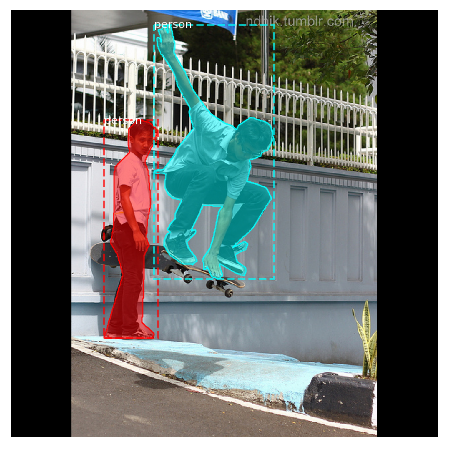

In [14]:
import random
from mrcnn.utils import log
from mrcnn import visualize
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    data.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


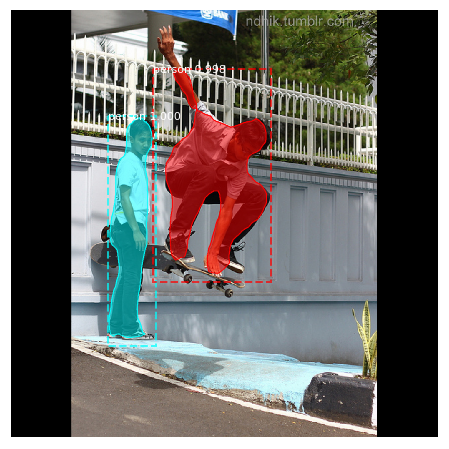

In [29]:
import matplotlib
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model_utils.detect(inference_model, [original_image], config, verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], ax=get_ax())

## Test on Customized Image

In [0]:
import skimage.io
image = skimage.io.imread("/content/drive/My Drive/Paper-Implementation-and-Deployment/Mask RCNN/test_image/3.jpg")

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


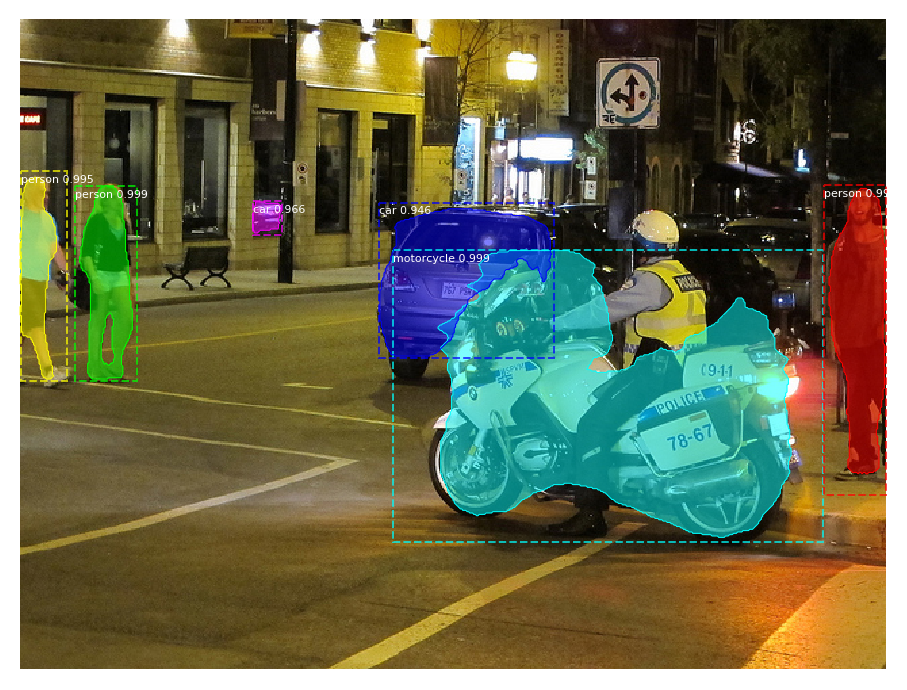

In [41]:
# Run detection
results = model_utils.detect(inference_model, [image], config, verbose=1, threshold=0.9)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Accurancy Test

In [0]:
def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": data.maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results

In [0]:
import time
def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model_utils.detect(inference_model, [image], config, verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = data.COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

In [0]:
# Validation dataset
# This will hit the error `name 'unicode' is not defined` at some point
# go to the file /usr/local/lib/python3.6/dist-packages/pycocotools/coco.py line 308
# change `if type(resFile) == str or type(resFile) == unicode:`
# to `if type(resFile) == str:`
# and restart runtime!
dataset_val = data.CocoDataset()
val_type = "val" if args.year in '2017' else "minival"
if args.model == "new" or args.model == "last":
    coco = dataset_val.load_coco(args.dataset, val_type, year=args.year, class_ids=[i+1 for i in range(5)], return_coco=True)
else:
    coco = dataset_val.load_coco(args.dataset, val_type, year=args.year, return_coco=True)
dataset_val.prepare()
print("Running COCO evaluation on {} images.".format(args.limit))
evaluate_coco(inference_model, dataset_val, coco, "bbox", limit=int(args.limit))

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Running COCO evaluation on 500 images.
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.16s).
Accumulating evaluation results...
DONE (t=0.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.018
 Average Recall     (AR) @